# Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import tifffile as tiff
from pathlib import Path
import kagglehub
import warnings
warnings.filterwarnings('ignore')

# Configuration

In [3]:
IMG_SIZE = (64, 64)
BATCH_SIZE = 32
EPOCHS = 50
NUM_CLASSES = 10

CLASSES = [
    'AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway',
    'Industrial', 'Pasture', 'PermanentCrop', 'Residential',
    'River', 'SeaLake'
]

SPECTRAL_BANDS = [
    'Coastal Aerosol', 'Blue', 'Green', 'Red', 'Red Edge 1',
    'Red Edge 2', 'Red Edge 3', 'NIR', 'Red Edge 4',
    'Water Vapor', 'SWIR Cirrus', 'SWIR 1', 'SWIR 2'
]

CATEGORY_MAP = {
    'AnnualCrop': 'Agriculture',
    'Forest': 'Forest',
    'HerbaceousVegetation': 'Vegetation',
    'Highway': 'Roads',
    'Industrial': 'Urban',
    'Pasture': 'Agriculture',
    'PermanentCrop': 'Agriculture',
    'Residential': 'Urban',
    'River': 'Water',
    'SeaLake': 'Water'
}

print("Config Setup completed...")

Config Setup completed...


# Download data from kaggle

In [10]:
dataset_path = kagglehub.dataset_download("apollo2506/eurosat-dataset")

print("Dataset downloaded to:", dataset_path)

100%|██████████| 2.04G/2.04G [00:14<00:00, 147MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/apollo2506/eurosat-dataset/versions/6


# Data Loading....


In [4]:
def load_satellite_data(dataset_dir, img_size=IMG_SIZE):

    print("Loading Data...")

    data = []
    labels = []
    class_folders = sorted(os.listdir(dataset_dir))

    for class_name in class_folders:
        class_path = os.path.join(dataset_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        # print(f"📂 Loading class: {class_name}...")
        for file_name in os.listdir(class_path):
            img_path = os.path.join(class_path, file_name)
            try:
                # Read 13-band Sentinel-2 image
                img = tiff.imread(img_path)
                # Ensure correct shape (64x64x13)
                if img.shape[-1] != 13:
                    print(f"⚠️ Skipping {img_path}: unexpected band count {img.shape[-1]}")
                    continue

                # Normalize values to [0, 1]
                img = img.astype(np.float32)
                img /= img.max()

                data.append(img)
                labels.append(class_name)

            except Exception as e:
                print(f"⚠️ Skipping {img_path}: {e}")

    X = np.array(data)
    Y = np.array(labels)
    return X, Y

# Load data
DATASET_PATH ="/root/.cache/kagglehub/datasets/apollo2506/eurosat-dataset/versions/6/EuroSATallBands"

X, Y = load_satellite_data(DATASET_PATH)

print(f"\n✅ Loaded {len(X)} samples successfully.")
print(f"Data shape: {X.shape}")
print(f"Labels shape: {Y.shape}")
print(f"Classes found: {sorted(CLASSES)}")


Loading Data...

✅ Loaded 27597 samples successfully.
Data shape: (27597, 64, 64, 13)
Labels shape: (27597,)
Classes found: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


# Data Exploration

=== BASIC DATA EXPLORATION ===

Class Distribution:
AnnualCrop: 3000 samples
Forest: 3000 samples
HerbaceousVegetation: 3000 samples
Highway: 2500 samples
Industrial: 2500 samples
Pasture: 2000 samples
PermanentCrop: 2500 samples
Residential: 3000 samples
River: 2500 samples
SeaLake: 3597 samples


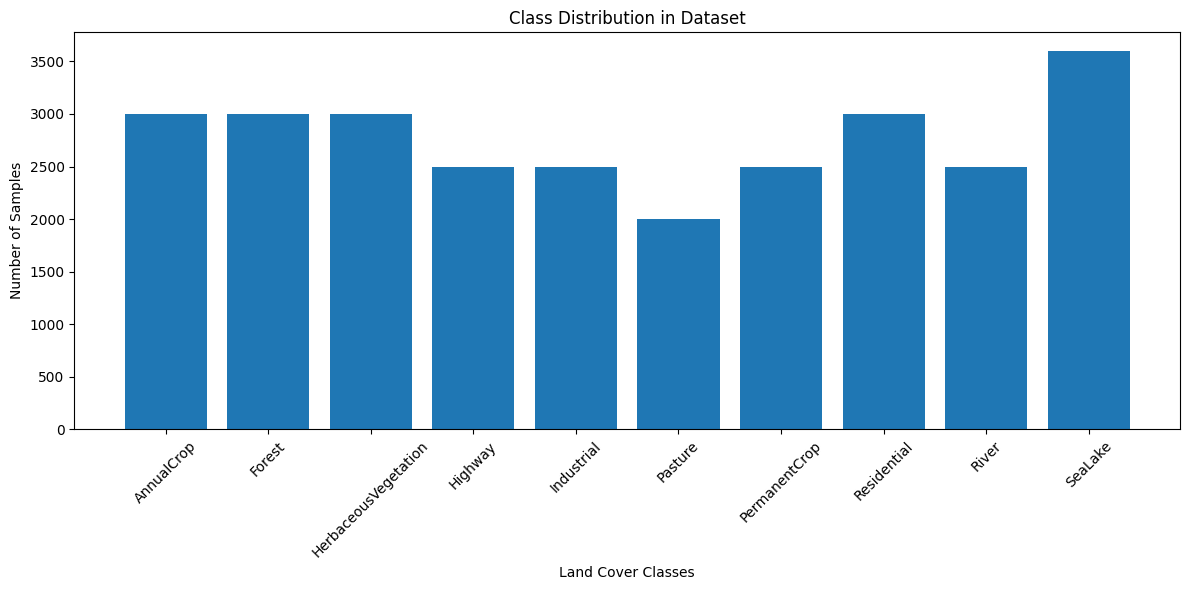


Data Shape Information:
Total samples: 27597
Image dimensions: 64 x 64
Number of spectral bands: 13


In [5]:
print("## BASIC DATA EXPLORATION ##")

unique_classes, counts = np.unique(Y, return_counts=True)
class_distribution = dict(zip(unique_classes, counts))

print("\nClass Distribution:")
for class_name, count in class_distribution.items():
    print(f"{class_name}: {count} samples")


plt.figure(figsize=(12, 6))
plt.bar(class_distribution.keys(), class_distribution.values())
plt.title('Class Distribution in Dataset')
plt.xlabel('Land Cover Classes')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


print(f"\nData Shape Information:")
print(f"Total samples: {X.shape[0]}")
print(f"Image dimensions: {X.shape[1]} x {X.shape[2]}")
print(f"Number of spectral bands: {X.shape[3]}")

# SPECTRAL ANALYSIS

## SPECTRAL ANALYSIS ##


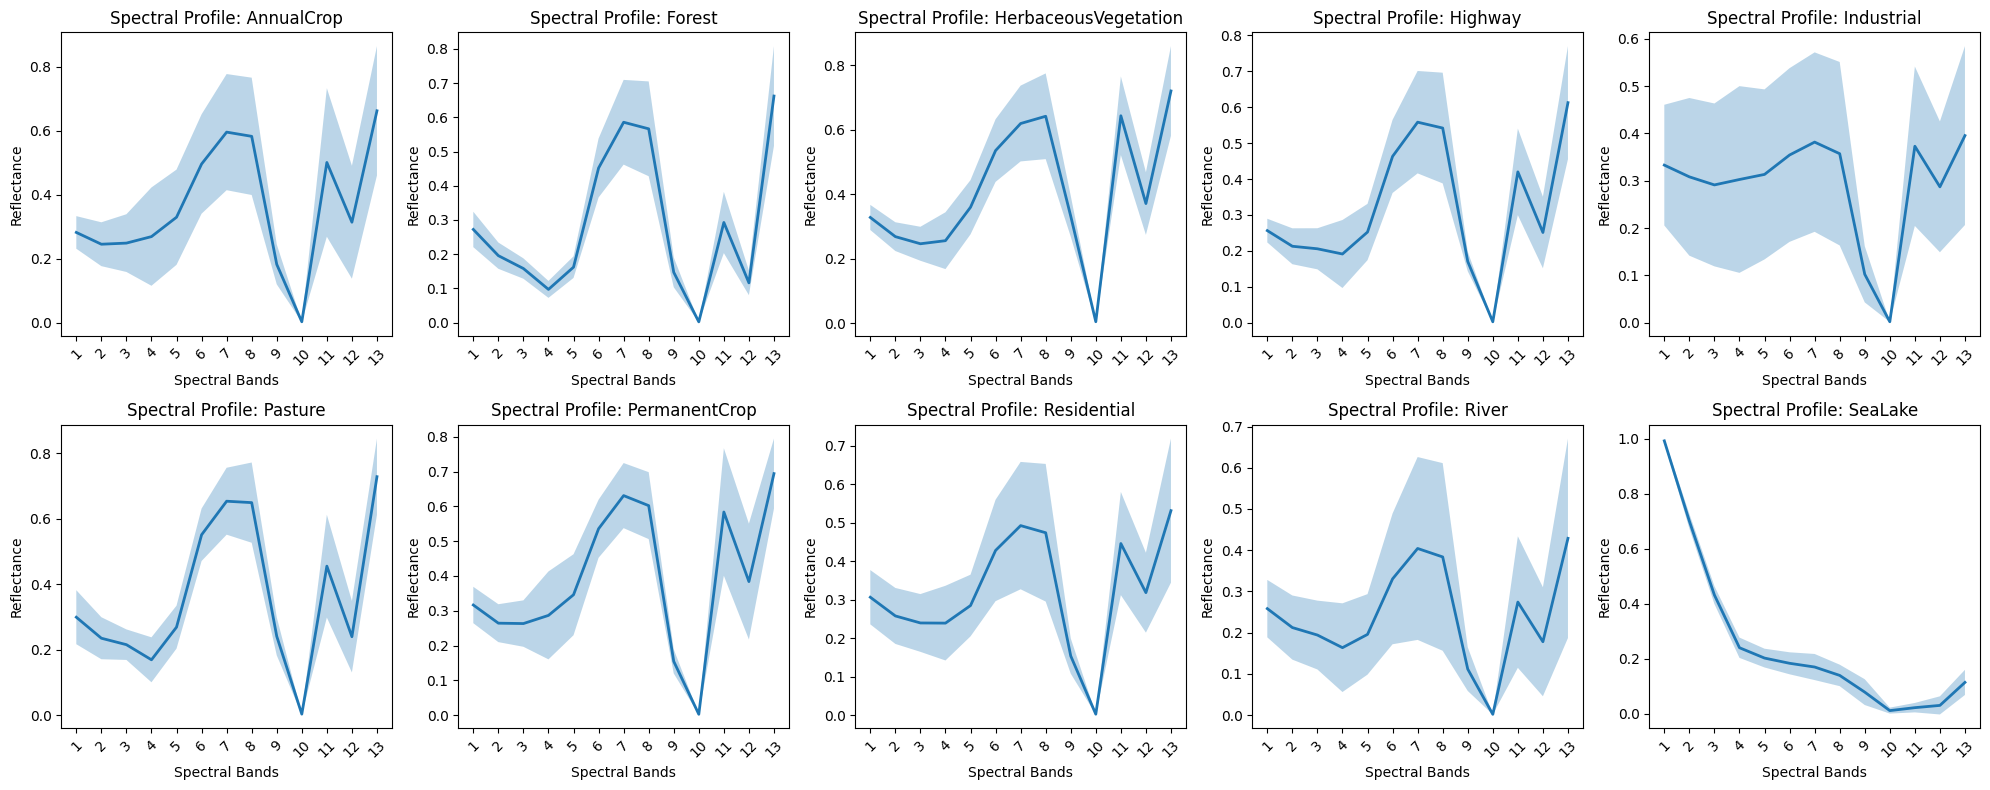

In [6]:
print("## SPECTRAL ANALYSIS ##")

# Plot spectral profiles for different land types
def plot_spectral_profiles(data, labels, n_samples_per_class=5):
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.ravel()

    for i, class_name in enumerate(CLASSES):
        class_indices = np.where(labels == class_name)[0][:n_samples_per_class]

        # Calculate mean spectral profile
        mean_spectrum = np.mean(data[class_indices], axis=(0, 1, 2))
        std_spectrum = np.std(data[class_indices], axis=(0, 1, 2))

        axes[i].plot(range(len(SPECTRAL_BANDS)), mean_spectrum,
                    label=class_name, linewidth=2)
        axes[i].fill_between(range(len(SPECTRAL_BANDS)),
                           mean_spectrum - std_spectrum,
                           mean_spectrum + std_spectrum, alpha=0.3)

        axes[i].set_title(f'Spectral Profile: {class_name}')
        axes[i].set_xlabel('Spectral Bands')
        axes[i].set_ylabel('Reflectance')
        axes[i].set_xticks(range(len(SPECTRAL_BANDS)))
        axes[i].set_xticklabels(range(1, 14), rotation=45)

    plt.tight_layout()
    plt.show()

plot_spectral_profiles(X, Y)

# Sample Images Visualization

## SAMPLE IMAGES VISUALIZATION ##


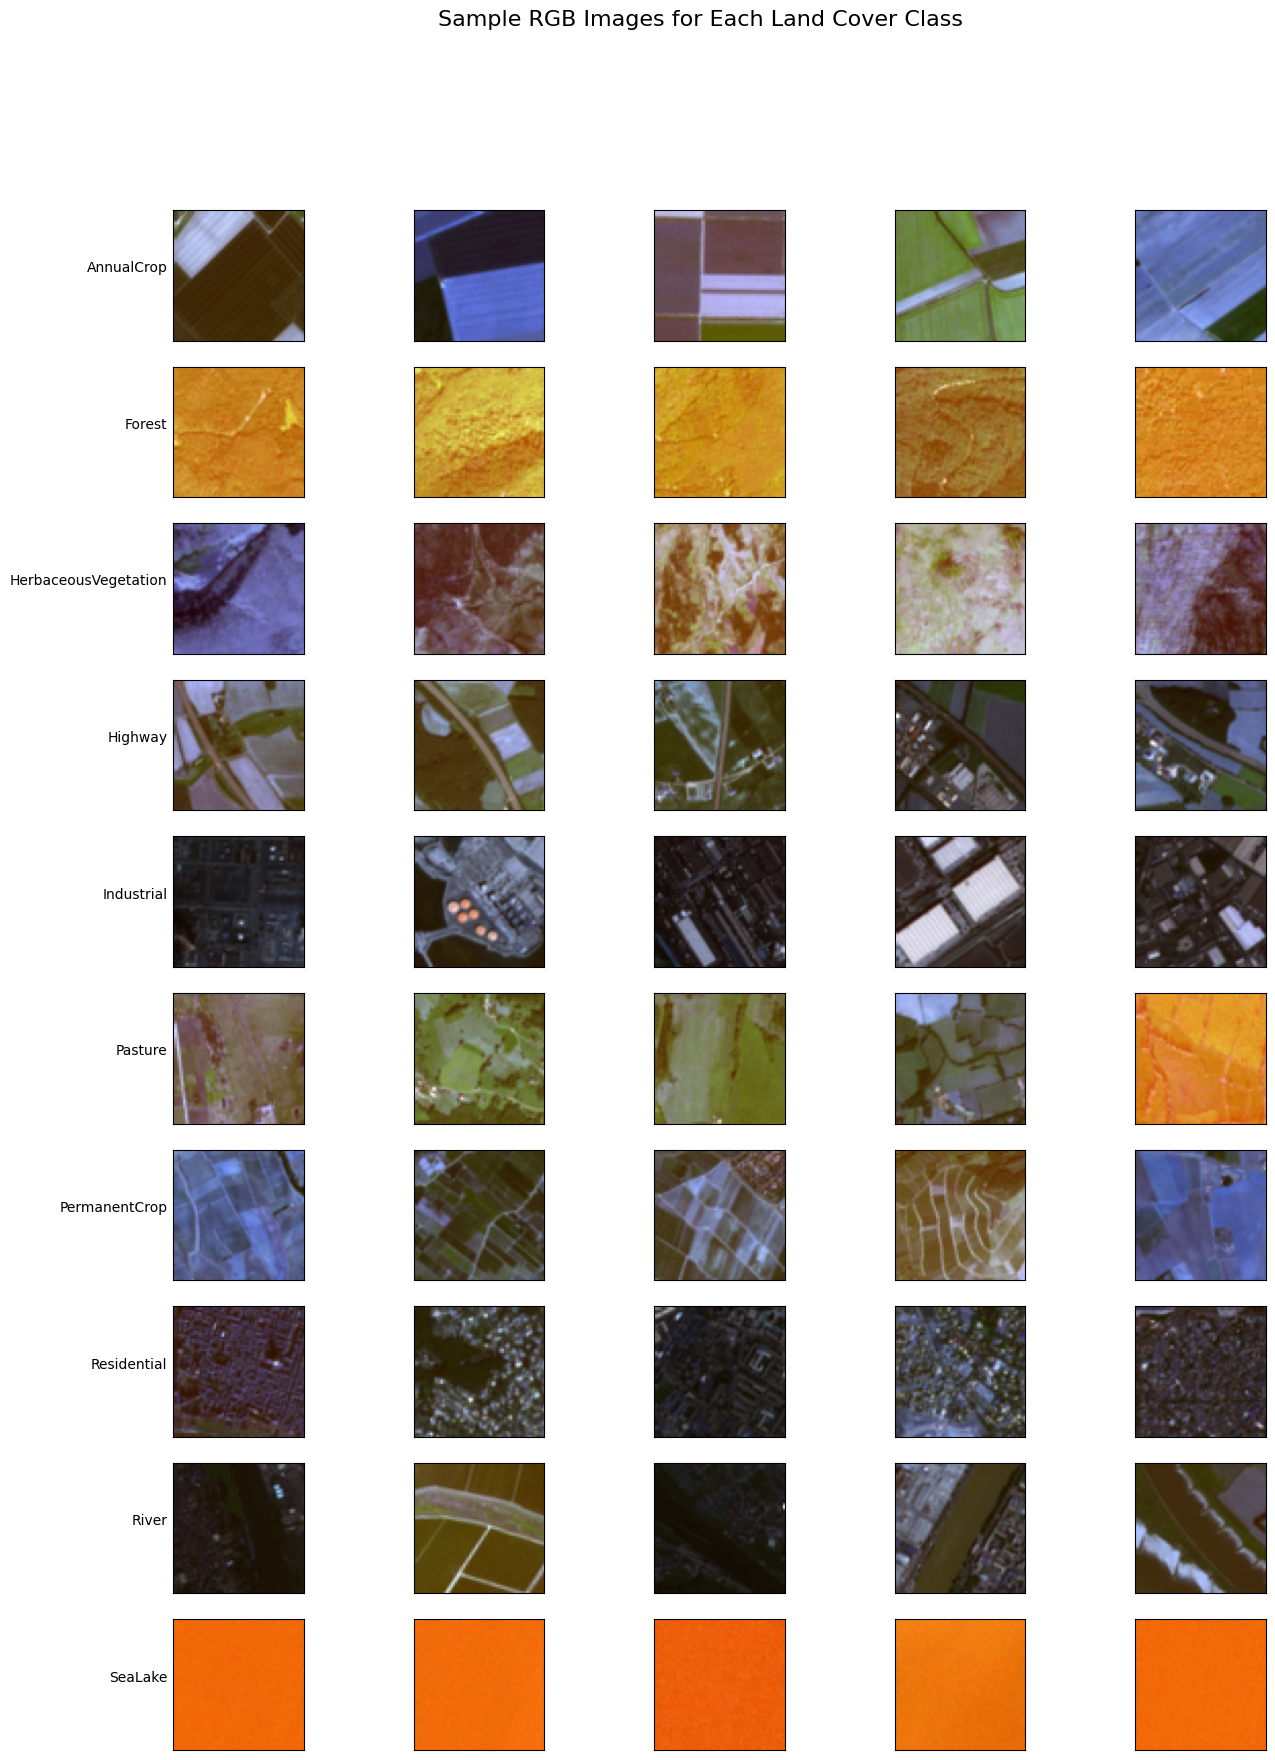

In [17]:
print("## SAMPLE IMAGES VISUALIZATION ##")

def plot_sample_images(data, labels, n_samples=5):
    """Plot sample RGB images from each class"""
    # Use bands 2, 3, 4 for RGB (Blue, Green, Red)
    rgb_indices = [1, 2, 3]

    fig, axes = plt.subplots(len(CLASSES), n_samples, figsize=(15,20))

    for i, class_name in enumerate(CLASSES):
        class_indices = np.where(labels == class_name)[0][:n_samples]

        for j, idx in enumerate(class_indices):
            rgb_image = data[idx][:, :, rgb_indices]

            rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())

            axes[i, j].imshow(rgb_image)
            if j == 0:
                axes[i, j].set_ylabel(class_name, rotation=0, ha='right')
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])

    plt.suptitle('Sample RGB Images for Each Land Cover Class', fontsize=16)
    # plt.tight_layout()
    plt.show()

plot_sample_images(X, Y)